In [2]:
# Jairo Andres Saavedra Alfonso
# 01 de Febrero de 2019
# Universidad de Los Andes
# Phycis 
######################__________________Weekly Report__________________######################
# Beta 1.0

In [3]:
#Packages
from astropy.io import fits
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.utils.data
import time
import os

cmd='jupyter nbconvert --to python SpectraNET_R.ipynb'
os.system(cmd)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print('This net is brought to you by',device)

This net is brought to you by cpu


In [4]:
N_sample=10000
batch_size=480
n_iter=10000

test_size=0.2 # 20%
val_size=0.25 # 25% of trainning size

n_train=int(N_sample*(1-test_size)*(1-val_size))
epochs = int(n_iter / (n_train / batch_size))

print('INFO: Epochs:{} -- Batch size:{}'.format(epochs,batch_size))

INFO: Epochs:800 -- Batch size:480


In [5]:
start=time.time()

def Load_Files(file_1,file_2,N_sample,objts,classification=True):
    hdul = fits.open(file_1) # Open file 1 -- 'truth_DR12Q.fits'
    info=hdul.info() # File info
    columns=hdul[1].columns # File Columns 
    print('INFO:',info,'/n',columns)
    data=hdul[1].data # Database of spectra with human-expert classifications 

    # Reading data from data_dr12.fits. This file had the spectra from data dr12. 
    hdul_2 = fits.open(file_2) # Open file 2 -- 'data_dr12.fits'
    info2=hdul_2.info() # File info 
    columns2=hdul_2[1].columns # File Columns
    print('INFO:',info2,'/n',columns2)
    data2=hdul_2[1].data # Database of spectra
    spectra=hdul_2[0].data # Spectrum of each object 
    
    # Subset of PLATE parameters of both data
    data_PLATE_1=data['PLATE']
    data_PLATE_2=data2['PLATE']

    # Subset of MJD parameters of both data
    data_MJD_1=data['MJD']
    data_MJD_2=data2['MJD']

    # Subset of FIBERID parameters of both data
    data_FIBERID_1=data['FIBERID']
    data_FIBERID_2=data2['FIBERID']
    data_ID_1=data['THING_ID']
    data_ID_2=data2['TARGETID']
    
    objts=np.asarray(objts)
    
    # The column 'CLASS_PERSON' have a class identifier for each spectrum: STARS=1, GALAXY=4, QSO=3 and QSO_BAL=30.
    C_P=data['CLASS_PERSON'] #Class Person column 
    STAR=C_P[C_P==1] # objects classified as stars
    GALAXY=C_P[C_P==4] # objects classified as galaxies 
    QSO=C_P[C_P==3] # objects classified as QSO (Quasars)
    QSO_BAL=C_P[C_P==30] # objects classified as QSO BAL (Quasars with Broad Absortions Lines)
    N_C=C_P[C_P!=30]   
    N_C=N_C[N_C!=3]
    N_C=N_C[N_C!=1]
    N_C=N_C[N_C!=4] # objects wrong classified
    
    print('Star:',STAR.shape)
    print('Galaxy:',GALAXY.shape)
    print('QSO:',QSO.shape)
    print('QSO BAL:',QSO_BAL.shape)
    print('NN:',N_C.shape)
    
    # I create two DataFrame for Superset_DR12Q and data_dr12 with only three parameters
    data1={'PLATE':data_PLATE_1,'MJD':data_MJD_1,'FIBERID':data_FIBERID_1,'ID':data_ID_1}
    data1=pd.DataFrame(data=data1)

    data2={'PLATE':data_PLATE_2,'MJD':data_MJD_2,'FIBERID':data_FIBERID_2,'ID':data_ID_2}
    data2=pd.DataFrame(data=data2)

    # I convert all objects in both set to string chain in orden to combine them as one new ID.
    data1['PLATE']=data1['PLATE'].astype(str)
    data1['MJD']=data1['MJD'].astype(str)
    data1['FIBERID']=data1['FIBERID'].astype(str)
    data1['PM'] = data1['MJD'].str.cat(data1['FIBERID'],sep="-")
    data1['NEWID'] = data1['PLATE'].str.cat(data1['PM'],sep="-")
    data_1=data1.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values

    data2['PLATE']=data2['PLATE'].astype(str)
    data2['MJD']=data2['MJD'].astype(str)
    data2['FIBERID']=data2['FIBERID'].astype(str)
    data2['PM'] = data2['MJD'].str.cat(data2['FIBERID'],sep="-")
    data2['NEWID'] = data2['PLATE'].str.cat(data2['PM'],sep="-")
    data_2=data2.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values # New set of database 2 with new ID's

    # With the routine of numpy intersect1d, I find the intersections elements in both sets. This elements  
    data_CO=np.array(np.intersect1d(data_1,data_2,return_indices=True))

    data_CO_objects=data_CO[0] # The unique new ID of each element in both sets
    data_CO_ind1=data_CO[1] # Indices of intersected elements from the original data 1 (Superset_DR12Q.fits) 
    data_CO_ind2=data_CO[2] # Indices of intersected elements form the original data 2 (data_dr12.fits)
    print('I find',len(data_CO_objects),'objects with spectra from DR12')
    #print(data_CO_ind1,data_CO_ind2)
    indi={'ind1':data_CO_ind1,'ind2':data_CO_ind2}
    ind=pd.DataFrame(data=indi,index=data_CO_ind1)

    cp=np.array(data['CLASS_PERSON'],dtype=float)
    z=np.array(data['Z_VI'],dtype=float)
    zc=np.array(data['Z_CONF_PERSON'],dtype=float)
    bal=np.array(data['BAL_FLAG_VI'],dtype=float)
    bi=np.array(data['BI_CIV'],dtype=float)

    d={'CLASS_PERSON':cp,'Z_VI':z,'Z_CONF_PERSON':zc,'BAL_FLAG_VI':bal,'BI_CIV':bi}
    data_0=pd.DataFrame(data=d)#.values #super database
    
    obj=data_0.loc[data_CO_ind1]
    
    if(classification!=True):

        if(objts[0]=='QSO'):
            qsos=obj.loc[obj['CLASS_PERSON']==3]
            sample_objects=qsos.sample(n=int(N_sample),weights='CLASS_PERSON', random_state=5)
            
            indi=np.array(sample_objects.index)
            indi1=ind.loc[indi].values
            
        elif(objts[0]=='QSO_BAL'):
            qsos_bal=obj.loc[obj['CLASS_PERSON']==30]
            sample_objects=qsos_bal.sample(n=int(N_sample),weights='CLASS_PERSON', random_state=5)
            
            indi=np.array(sample_objects.index)
            indi1=ind.loc[indi].values
            
        elif(len(objts)==2):
            qsos=obj.loc[obj['CLASS_PERSON']==3]
            qsos_bal=obj.loc[obj['CLASS_PERSON']==30]    
            
            sample_qso=qsos.sample(n=int(N_sample/2),weights='CLASS_PERSON', random_state=5)
            sample_qso_bal=qsos_bal.sample(n=int(N_sample/2),weights='CLASS_PERSON', random_state=5)
            sample_objects=pd.concat([sample_qso,sample_qso_bal])
            
            ind_qso=np.array(sample_qso.index)
            ind_qso_bal=np.array(sample_qso_bal.index)
            
            indi=np.concatenate((ind_qso,ind_qso_bal), axis=None)
            indi1=ind.loc[indi].values

        spectra_=np.zeros((N_sample,886))
            
        j=0
        for i in indi:
            k=indi1[j,1]
            spectra_[j,:]=spectra[k,:]
            j=j+1    
            
        spectra_=pd.DataFrame(spectra_)
        X=spectra_.values
        
        mean_flx= np.ma.average(X[:,:443], weights=X[:,443:],axis=1)
        ll=(X[:,:443]-mean_flx.reshape(-1,1))**2
        aveflux=np.ma.average(ll, weights=X[:,443:],axis=1)
        sflux = np.sqrt(aveflux)
        X = (X[:,:443]-mean_flx.reshape(-1,1))/sflux.reshape(-1,1)        
        
        y=sample_objects['Z_VI']
        #y_max=torch.max(y)
        #y=y/y_max
        y=np.array(y,dtype=float)
        y_max=np.max(y)
        y=y/y_max
        print(y)
        return X,y
            
    stars=obj.loc[obj['CLASS_PERSON']==1]
    galaxies=obj.loc[obj['CLASS_PERSON']==4]
    qsos=obj.loc[obj['CLASS_PERSON']==3]
    qsos_bal=obj.loc[obj['CLASS_PERSON']==30]

    sample_star=stars.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_galaxy=galaxies.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso=qsos.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso_bal=qsos_bal.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)

    sample_objects=pd.concat([sample_star,sample_galaxy,sample_qso,sample_qso_bal])

    ind_star=np.array(sample_star.index)
    ind_galaxy=np.array(sample_galaxy.index)
    ind_qso=np.array(sample_qso.index)
    ind_qso_bal=np.array(sample_qso_bal.index)

    indi=np.concatenate((ind_star, ind_galaxy,ind_qso,ind_qso_bal), axis=None)
    indi1=ind.loc[indi].values

    spectra_=np.zeros((N_sample,886))
    j=0
    for i in indi:
        k=indi1[j,1]
        spectra_[j,:]=spectra[k,:]#np.log(abs(spectra[k,:443]))
        j=j+1    
        
        
    spectra_=pd.DataFrame(spectra_)
    X=spectra_.values
    
    #Renormalize spectra
    
    mean_flx= np.ma.average(X[:,:443], weights=X[:,443:],axis=1)
    ll=(X[:,:443]-mean_flx.reshape(-1,1))**2
    aveflux=np.ma.average(ll, weights=X[:,443:],axis=1)
    sflux = np.sqrt(aveflux)
    X = (X[:,:443]-mean_flx.reshape(-1,1))/sflux.reshape(-1,1)

    y=sample_objects['CLASS_PERSON']
    y=y.replace([1, 4, 3, 30], [0,1,2,3]).values
    y=np.array(y,dtype=float)
    
    return X,y


def Loader(X,y,N_sample):

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    
    train_data = []
    
    for i in range(y_train.shape[0]):
        xt=X_train[i,:].reshape(1,-1)
        train_data.append([Variable(torch.tensor(xt, dtype=torch.float)), torch.tensor(y_train[i], dtype=torch.float)])
    
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

    test_data = []
    for i in range(y_test.shape[0]):
        xtst=X_test[i,:].reshape(1,-1)
        test_data.append([Variable(torch.tensor(xtst, dtype=torch.float)), torch.tensor(y_test[i], dtype=torch.float)])
    
    test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    val_data = []
    for i in range(y_val.shape[0]):
        xv=X_val[i,:].reshape(1,-1)
        val_data.append([Variable(torch.tensor(xv, dtype=torch.float)), torch.tensor(y_val[i], dtype=torch.float)])
    
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)
    
    print('INFO')
    print('Train shape:',y_train.shape[0])
    print('Val shape:',y_val.shape[0])
    print('Test shape:',y_test.shape[0])
    return train_loader,test_loader,val_loader

In [6]:
X,y=Load_Files('truth_DR12Q.fits','data_dr12.fits',N_sample,['QSO'],classification=False)
train_loader,test_loader,val_loader=Loader(X,y,N_sample)

Filename: truth_DR12Q.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     27   546856R x 9C   [J, D, J, J, J, J, J, D, D]   
INFO: None /n ColDefs(
    name = 'THING_ID'; format = 'J'
    name = 'Z_VI'; format = 'D'
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
    name = 'CLASS_PERSON'; format = 'J'
    name = 'Z_CONF_PERSON'; format = 'J'
    name = 'BAL_FLAG_VI'; format = 'D'
    name = 'BI_CIV'; format = 'D'
)
Filename: data_dr12.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (886, 639464)   float64   
  1                1 BinTableHDU     16   639464R x 4C   [J, J, J, J]   
INFO: None /n ColDefs(
    name = 'TARGETID'; format = 'J'
    name = 'PLATE'; format = 'J'
    name = 'MJD'; format = 'J'
    name = 'FIBERID'; format = 'J'
)
Star: (207915,)
Galaxy: (22795,)
QSO:

In [7]:
class Net_R(nn.Module):
    def __init__(self):
        super(Net_R, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 10,stride=2)
        self.conv2 = nn.Conv1d(64, 128, 10,stride=2)
        self.conv3 = nn.Conv1d(128, 256, 10,stride=2)
        self.conv4 = nn.Conv1d(256, 256, 10,stride=2)
        self.pool = nn.MaxPool1d(2, 1)
        self.fc1 = nn.Linear(4608, 128)
        self.bn=nn.BatchNorm1d(128)
        #self.fc1 = nn.Linear(10300, 16)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout=nn.Dropout(0.5)


    def forward(self, x):
        in_size = x.size(0)
        x = self.pool(F.relu(self.conv1(x)))
        ##x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(in_size, -1)
        #x = self.fc1(x)
        x = F.relu(self.fc1(x))     
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    


Net_R(
  (conv1): Conv1d(1, 64, kernel_size=(10,), stride=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(10,), stride=(2,))
  (conv3): Conv1d(128, 256, kernel_size=(10,), stride=(2,))
  (conv4): Conv1d(256, 256, kernel_size=(10,), stride=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)
Epoc: 1
Batch: 1 <--> Loss: 0.6860418319702148
Batch: 2 <--> Loss: 0.4229004979133606
Batch: 3 <--> Loss: 0.23446185886859894
Batch: 4 <--> Loss: 0.18533842265605927
Batch: 5 <--> Loss: 0.16593943536281586
Batch: 6 <--> Loss: 0.16003678739070892
Batch: 7 <--> Loss: 0.16509999334812164
Batch: 8 <--> Loss: 0.15018686652183533
Batch: 9 <--> Loss: 0.14357836544513702
Batc

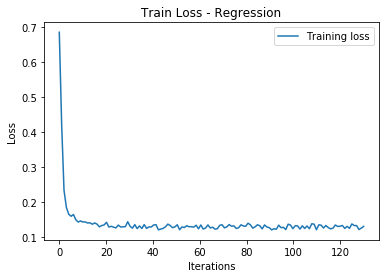

In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support

learning_rate=0.01
log_interval=10
epoc=10

net_R = Net_R()
print(net_R)

optimizer = torch.optim.SGD(net_R.parameters(), lr=0.2) #for Rgrss
loss_func = torch.nn.L1Loss()


loss_=[]
def train(epoch):
    #model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader,0):
        data, target = Variable(data), Variable(target)
       
        optimizer.zero_grad()
        
        output = net_R(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
        loss_.append(running_loss)
        print('Batch:',batch_idx+1,'<-->','Loss:',running_loss)
        #if(batch_idx !=0):    # print every 2000 mini-batches
            #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            #running_loss = 0.0
    


# Training loop
for i in range(epoc):
    print('Epoc:',i+1)
    train(i)
    
    
print('Finished Training')

loss_=np.asarray(loss_)

epoch=np.linspace(0,len(loss_),len(loss_))

plt.plot(epoch,loss_,label='Training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Train Loss - Regression')
plt.legend()
plt.savefig('Train_loss_Regression.jpg')


In [11]:
correct = 0
total = 0
d=[]
d1=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_R(images)
        #_, predicted = torch.max(outputs.data, 1)
        #print(predicted,predicted.shape)
        outputs=outputs.view(outputs.size(0),-1)
        d.append(outputs)
        d1.append(labels)

        

#print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
#d=np.asarray(d)

#print(d[0])
d=d[0]
d=d.reshape(1,-1)
print(d1[0])
print(d[0])
y_pred=d[0]
y_test=d1[0]

end=time.time()
df=end-start
print('Time:',df)

tensor([0.5442, 0.2538, 0.4924, 0.5919, 0.4250, 0.4761, 0.4473, 0.3281, 0.4341,
        0.4705, 0.5196, 0.3423, 0.4678, 0.4705, 0.5155, 0.4812, 0.1456, 0.1547,
        0.5287, 0.3819, 0.4530, 0.3762, 0.3675, 0.4294, 0.2420, 0.4983, 0.4853,
        0.4238, 0.5356, 0.4948, 0.4132, 0.5322, 0.5202, 0.2024, 0.1393, 0.4217,
        0.1578, 0.1257, 0.1773, 0.2102, 0.5458, 0.4711, 0.3988, 0.4800, 0.4701,
        0.5460, 0.4747, 0.1909, 0.4719, 0.4995, 0.5626, 0.3513, 0.5170, 0.4644,
        0.4887, 0.7553, 0.1647, 0.3799, 0.3468, 0.5803, 0.4540, 0.5220, 0.1791,
        0.4508, 0.5543, 0.6640, 0.1200, 0.7842, 0.4725, 0.6008, 0.6439, 0.3403,
        0.5655, 0.4597, 0.2698, 0.1925, 0.4211, 0.6327, 0.1498, 0.1653, 0.6126,
        0.4747, 0.2532, 0.1695, 0.4617, 0.4711, 0.5283, 0.5375, 0.4491, 0.7736,
        0.1259, 0.2755, 0.1387, 0.4528, 0.5614, 0.5007, 0.1525, 0.4918, 0.4902,
        0.1555, 0.5444, 0.1364, 0.4820, 0.4004, 0.2053, 0.5817, 0.5251, 0.4469,
        0.4956, 0.4288, 0.5216, 0.4591, 

In [10]:
#from sklearn import metrics
#print(y_pred,y_test)
#fpr, tpr, thresholds = metrics.roc_curve(y_pred, y_test)
#plt.plot(fpr,tpr)